Importing libraries

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import os

In [2]:
class ETLPipeline:
    def __init__(self, input_path, output_path):
        """Initialize the pipeline with input and output file paths."""
        self.input_path = input_path
        self.output_path = output_path
        self.df = None

    def extract(self):
        """Load and clean the data."""
        print("Extracting data...")
        if not os.path.exists(self.input_path):
            raise FileNotFoundError(f"Input file {self.input_path} not found.")
        self.df = pd.read_csv(self.input_path)
        
        # Convert TotalCharges to numeric, handling errors
        self.df['TotalCharges'] = pd.to_numeric(self.df['TotalCharges'], errors='coerce')
        # Drop customerID as it’s not useful for analysis
        self.df = self.df.drop('customerID', axis=1)
        print("Data extracted and cleaned.")
        return self

    def transform(self):
        """Preprocess and transform the data."""
        print("Transforming data...")
        # Separate features and target
        feature_cols = [col for col in self.df.columns if col != 'Churn']
        target_col = 'Churn'

        # Clean numeric columns that might be stored as strings
        numeric_columns = ['TotalCharges', 'MonthlyCharges']
        for col in numeric_columns:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                self.df[col] = self.df[col].fillna(0)
        
        # Your existing transformations
        self.df['tenure_group'] = pd.cut(self.df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                                        labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
        self.df['charges_per_month'] = self.df['TotalCharges'] / self.df['tenure'].replace(0, 1)
        self.df['total_services'] = self.df[['PhoneService', 'InternetService', 'OnlineSecurity']].eq('Yes').sum(axis=1)

        # Identify numerical and categorical feature columns
        numerical_cols = [col for col in feature_cols if self.df[col].dtype in ['int64', 'float64']]
        categorical_cols = [col for col in feature_cols if self.df[col].dtype == 'object']

        # Define transformers
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Scale numerical features
        ])
        categorical_transformer = Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categorical features
        ])

        # Combine transformers into a ColumnTransformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ]
        )

        # Transform features
        transformed_features = preprocessor.fit_transform(self.df[feature_cols])
        cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
        feature_names = list(numerical_cols) + list(cat_feature_names)
        features_df = pd.DataFrame(transformed_features, columns=feature_names)

        # Encode target variable (Churn: Yes/No to 1/0)
        le = LabelEncoder()
        target = le.fit_transform(self.df[target_col])

        # Combine transformed features and target
        self.df = pd.concat([features_df, pd.Series(target, name='Churn')], axis=1)
        print("Data transformed.")
        return self

    def load(self):
        """Save the transformed data to a file."""
        print("Loading data...")
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)  # Ensure output directory exists
        self.df.to_csv(self.output_path, index=False)
        print(f"Data saved to {self.output_path}")
        return self

    def run(self):
        """Run the entire ETL process."""
        self.extract().transform().load()

In [3]:
if __name__ == "__main__":
    input_file = "Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv"
    output_file = "./processed_data.csv"
    pipeline = ETLPipeline(input_file, output_file)
    pipeline.run()

Extracting data...
Data extracted and cleaned.
Transforming data...
Data transformed.
Loading data...
Data saved to ./processed_data.csv


In [4]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv("Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean TotalCharges column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values in TotalCharges
# Option 1: Fill with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Option 2: Fill with median (alternative)
# df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Now create your feature engineering
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                           labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
df['charges_per_month'] = df['TotalCharges'] / df['tenure'].replace(0, 1)
df['total_services'] = df[['PhoneService', 'InternetService', 'OnlineSecurity']].eq('Yes').sum(axis=1)

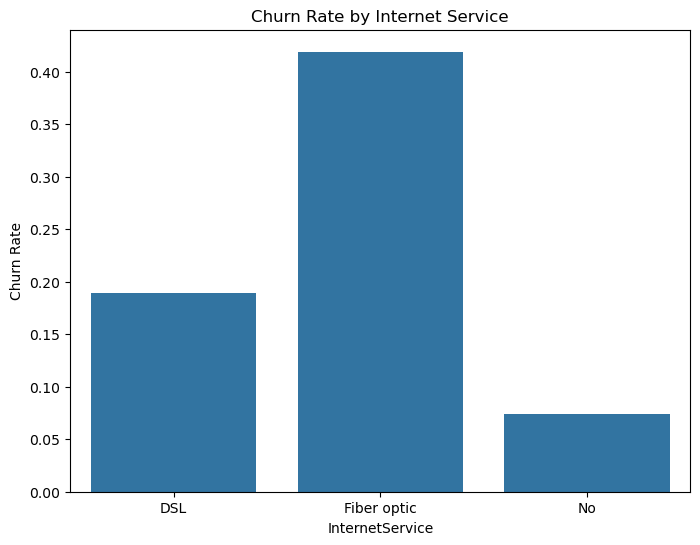

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a summary dataframe first
churn_by_internet = df.groupby('InternetService')['Churn'].apply(lambda x: (x == 'Yes').mean()).reset_index()
churn_by_internet.columns = ['InternetService', 'ChurnRate']

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(data=churn_by_internet, x='InternetService', y='ChurnRate')
plt.title('Churn Rate by Internet Service')
plt.ylabel('Churn Rate')
plt.show()

In [6]:
!pip install dash

from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(id='feature', options=[{'label': col, 'value': col} for col in ['InternetService', 'Contract']],
                 value='InternetService'),
    dcc.Graph(id='churn-bar')
])

@app.callback(
    Output('churn-bar', 'figure'), 
    Input('feature', 'value')
)
def update_graph(feature):
    fig = px.bar(df, x=feature, color='Churn', barmode='group', title=f'Churn by {feature}')
    return fig

app.run(debug=True)